In [1]:
%matplotlib inline  
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Make all necessary imports
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json
import itertools
from collections import defaultdict
from pymongo import MongoClient
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import os
import foursquare

In [2]:
OSMFILE = 'everett.osm'
JSONFILE = 'everett.osm.json'
SAMPLE_OSMFILE = 'sample_everett.osm'
SAMPLE_JSONFILE = 'sample_everett.osm.json'
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

## Database connection

In [3]:
client = MongoClient("mongodb://localhost:27017")
db = client.osm

## Data preparation for mongodb

In [5]:
def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way" :
        node["created"] = {}
        node['type'] = element.tag
        ats = element.attrib 
        for k in ats:
            if problemchars.search(k):
                continue
            if k in CREATED:
                node["created"][k] = ats[k]
                continue
            if k in ['lat', 'lon']:
                if not node.get('pos'):
                    node['pos'] = [None] * 2
                if k == "lon":
                    node["pos"][1] = float(ats[k])
                else: 
                    node["pos"][0] = float(ats[k])
                continue
            for tag in element:
                if tag.tag == 'nd':
                    if not node.get('node_refs'):
                        node['node_refs'] = []
                    node["node_refs"].append(tag.attrib['ref'])
                    continue
                if tag.tag == 'tag':
                    tats = tag.attrib
                    lc = lower_colon.search(tats['k'])
                    if lc:
                        if not node.get('address'):
                            node['address'] = {}
                        addr = tats['k'].split(':')
                        if addr[0] == 'addr' and len(addr) == 2:
                            node["address"][addr[1]] = tats['v']
                        continue
                    else:
                        node[tats['k']] = tats['v']
                        continue
                node
            node[k] = ats[k]
        pprint.pprint(node)
        return node
    else:
        return None

In [83]:
def process_map(file_in, file_out, pretty = False):
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

In [84]:
%%capture
data = process_map(OSMFILE, JSONFILE, False);

In [242]:
%%capture
data = process_map(SAMPLE_OSMFILE, SAMPLE_JSONFILE, False);

In [6]:
def count_tags(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    tags = get_tags(root)
    return tags

def get_tags(root):
    tags = {}
    tags[root.tag] = 1
    for child in root:
        ctags = get_tags(child)
        tag = child.tag
        for ctag in ctags:
            if ctag in tags:
                tags[ctag] += ctags[ctag]
            else:
                tags[ctag] = ctags[ctag]
    return tags

In [7]:
tags = count_tags('everett.osm')
pprint.pprint(tags)

{'member': 11739,
 'meta': 1,
 'nd': 759306,
 'node': 648752,
 'note': 1,
 'osm': 1,
 'relation': 1148,
 'tag': 481835,
 'way': 77915}


## Insert JSON Data to Database

In [88]:
# Remove old database
db.everett.drop()

# Load new data
with open(JSONFILE) as f:
    for line in f:
        data = json.loads(line)
        db.everett.insert_one(data)

## Statistics

In [89]:
# Total number of records:
total_records = db.everett.find().count()  
total_records

726667

In [90]:
# Number of nodes:
db.everett.find({"type":"node"}).count()

648750

In [93]:
# Number of ways:
db.everett.find({"type":"way"}).count()

77910

In [96]:
# Number of unique users
total_users = len(db.everett.distinct("created.user"))
total_users 

798

In [97]:
# Top 10 contributors
top_10 = db.everett.aggregate([{"$group":{"_id":"$created.user", "count":{"$sum":1}}},
                                 {"$sort":{"count":-1}},
                                 {"$limit":10}])
top_10_sum = 0 # Contributions by to 10 users
for doc in top_10:
    top_10_sum += doc['count']
    print(doc) 

{u'count': 137861, u'_id': u'SeattleImport'}
{u'count': 81156, u'_id': u'Glassman_Import'}
{u'count': 74552, u'_id': u'seattlefyi_import'}
{u'count': 61620, u'_id': u'STBrenden'}
{u'count': 47758, u'_id': u'Natfoot'}
{u'count': 41735, u'_id': u'Glassman'}
{u'count': 36935, u'_id': u'Heptazane'}
{u'count': 26208, u'_id': u'compdude'}
{u'count': 21789, u'_id': u'bdp'}
{u'count': 18174, u'_id': u'joelotz'}


In [98]:
# Top 10 percentage
float(top_10_sum)/total_records*100

75.3836351451215

In [100]:
# Number of users with 1 contribution
only_contribution_users = db.everett.aggregate([{"$group":{"_id":"$created.user", "count":{"$sum":1}}},
                                                 {"$group":{"_id":"$count", "num_users":{"$sum":1}}},
                                                 {"$sort":{"_id":1}},
                                                 {"$limit":1}]).next()['num_users']
only_contribution_users

236

In [101]:
# percent of users with 1 contribution
100.0*only_contribution_users/total_users

29.573934837092732

In [9]:
# Average contribution per user
for doc in db.everett.aggregate([{"$group":{"_id":"$created.user", "count":{"$sum":1}}},
                                 {"$group":{"_id": None, "average":{"$avg":"$count"}}}]):
    print(doc)

{u'average': 910.610275689223, u'_id': None}


In [10]:
# Contribution distribution
h = []
for d in db.everett.aggregate([{"$group":{"_id":"$created.user", "count":{"$sum":1}}},{"$sort":{"count":-1}}]):
    h.append(d['count'])

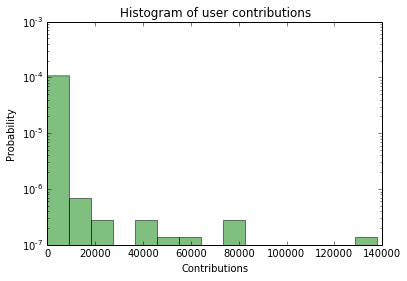

In [11]:
plt.xlabel('Contributions')
plt.ylabel('Probability')
plt.title(r'Histogram of user contributions')
plt.yscale('log', nonposy='clip')
plt.hist(h, bins=15, normed=True, facecolor='green', alpha=0.5)      #use this to draw histogram of your data
plt.show()   

## Problems in dataset
### Street names

In [12]:
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected_street_types = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons", 
            "Way"]
expected_modifiers = ["Highway", "North", "South", "West", "Northeast", "Northwest", "Southeast", "Southwest"]

mapping = { "St": "Street",
            "St.": "Street",
            "Ave": "Avenue",
            "Rd.": "Road"
            }

In [13]:
streets = db.everett.find( { "address.street": { "$regex": street_type_re } } )
streets.count()


32098

In [14]:
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected_street_types:
            street_types[street_type].add(street_name)
            
def update_name(name, mapping):
    st = street_type_re.search(name)
    if st:
        wrong = st.group(0)
        name = street_type_re.sub(mapping[wrong], name)
    return name

In [15]:
street_types = defaultdict(set)
# Not expected names:
for node in streets:
    audit_street_type(street_types, node['address']['street'])
# for st_type, ways in st_types.iteritems():
#     for name in ways:
#         better_name = update_name(name, mapping)
#         print name, "=>", better_name

### Phones

In [16]:
# Review phone numbers
phones = db.everett.find({"phone": { "$exists": True }})
for doc in phones:
    print doc['phone']


+1 206 362 6878
+1 425 377 2173
+1 425 482 9755
+1 360 863 0909
+1 206 440 2400
+1 425 672 1137
+1 360 221 3211
+1 206 462 1059
+1 425 884 8900
+1 425 485 3288
+1 360 657 1192
+1 425 402 9988
+1 425 486 8980
+1 425 488 8200
+1 425 486 9131
+1 425 489 9393
+1 425 788 2939
+1 425 788 9718
+1 425 788 1167
+1 206 363 1167
+1 425 949 5898
+1 425 949 5644
+1 425 489 8555
+1 800 233 2328
+1 206 365 2337
+1 206 367 0822
+1 206 361 1188
+1 206 365 3211
+1 360 805 5495
+1 360 805 9696
+1 425 488 2795
+1 425 742 6180
+1 425 485 1769
+1 425 486 1297
+1 425 485 4530
+1 425 468 6510
+1 425 486 5833
+1 425 486 6522
+1 425 398 0897
+1 425 806 0100
+1 425 486 7270
+1 425 485 7100
+1 425 486 5292
+1 425 398 wine
+1 425 485 5016
+1 425 482 9347
+1 425 482 6126
+1 425 481 utan
+1 425 775 7447
+1 425 673 7895
+1 206 726 1717
+1 425 672 1155
+1 425 747 2016
+1 425 823 5488
+1 425 771 0230
+1 360 657 5762
+1 425 423 7635
+1 425 778 7711
+1 360 805 1007
+1 360 658 7817
+1 360 659 0098
+1 360 760 2977
+1 360 6

In [26]:
# Fix phone numbers
def format_phone(phone):
    # Remove all not meaning symbols:     
    phone = phone.encode('ascii','ignore').translate(None, '-_ ()')
    
    # Add country code '+1'
    if len(phone) == 10:
        phone = '+1' + phone
    
    # Add '+' if bare country code
    if len(phone) == 11:
        phone = '+' + phone
    
    # Add spaces for readability
    if len(phone) == 12:
        phone = phone[0:2] + ' ' + phone[2:5] + ' ' + phone[5:8] + ' ' + phone[8:]
    
    return phone

In [18]:
# Update phone numbers
phones = db.everett.find({"phone": { "$exists": True }})
for doc in phones:
    new_phone = format_phone(doc["phone"])
    db.everett.update_one({'_id': doc['_id']}, {"$set": { 'phone': new_phone}})
    


## Cuisines

In [19]:
# Amenities with cusisine
amenities = db.everett.aggregate([{"$match": {"cuisine": { "$exists": True }}},
        {"$group":{"_id":"$amenity", "count":{"$sum":1}}},
                                 {"$sort":{"count":-1}}])
print '| Amenity type | Count |'
for doc in amenities:
    print "| " + str(doc['_id']) + " | " + str(doc['count']) + " |" 

| Amenity type | Count |
| restaurant | 131 |
| fast_food | 93 |
| cafe | 35 |
| None | 6 |
| pub | 2 |


In [20]:
# All Amenities of these types
all_amenities = db.everett.aggregate([{"$match": {"amenity": { "$in": ['restaurant', 'fast_food', 'cafe', 'pub']}}},
        {"$group":{"_id":"$amenity", "count":{"$sum":1}}},
                                 {"$sort":{"count":-1}}])
print '| Amenity type | Count |'
for doc in all_amenities:
    print "| " + str(doc['_id']) + " | " + str(doc['count']) + " |" 

| Amenity type | Count |
| restaurant | 257 |
| fast_food | 159 |
| cafe | 90 |
| pub | 24 |


In [21]:
cousines = db.everett.aggregate([{"$match": {"cuisine": { "$exists": True }}},
                                 {"$match": {"amenity": { "$in": ['restaurant', 'fast_food', 'cafe', 'pub']}}},
                                 {"$group":{"_id":"$cuisine", "count":{"$sum":1}}},
                                 {"$sort":{"count":-1}}])
for doc in cousines:
    print doc

{u'count': 48, u'_id': [u'burger']}
{u'count': 40, u'_id': [u'mexican']}
{u'count': 33, u'_id': [u'coffee_shop']}
{u'count': 27, u'_id': [u'pizza']}
{u'count': 23, u'_id': [u'sandwich']}
{u'count': 15, u'_id': [u'american']}
{u'count': 12, u'_id': [u'chinese']}
{u'count': 11, u'_id': [u'thai']}
{u'count': 7, u'_id': [u'italian']}
{u'count': 5, u'_id': [u'asian']}
{u'count': 4, u'_id': [u'regional']}
{u'count': 4, u'_id': [u'japanese']}
{u'count': 4, u'_id': [u'seafood']}
{u'count': 3, u'_id': [u'greek']}
{u'count': 3, u'_id': [u'chicken']}
{u'count': 3, u'_id': [u'vietnamese']}
{u'count': 3, u'_id': [u'sushi']}
{u'count': 2, u'_id': [u'international']}
{u'count': 2, u'_id': [u'ice_cream']}
{u'count': 2, u'_id': [u'teriyaki']}
{u'count': 1, u'_id': [u'hawaiian']}
{u'count': 1, u'_id': [u'donut']}
{u'count': 1, u'_id': [u'ice_cream', u'burger']}
{u'count': 1, u'_id': [u'indian']}
{u'count': 1, u'_id': [u'doughnut']}
{u'count': 1, u'_id': [u'mediterranean']}
{u'count': 1, u'_id': [u'ethio

In [22]:
amenities = db.everett.aggregate([{"$match": {"cuisine": { "$exists": True }}},
        {"$group":{"_id":"$amenity", "count":{"$sum":1}}},
                                 {"$sort":{"count":-1}}])
for doc in amenities:
    print doc

{u'count': 131, u'_id': u'restaurant'}
{u'count': 93, u'_id': u'fast_food'}
{u'count': 35, u'_id': u'cafe'}
{u'count': 6, u'_id': None}
{u'count': 2, u'_id': u'pub'}


In [23]:
cuisine_suffix = [
    '_restaurant',
    '_food' 
] 

In [24]:
#Fix cuisine
def format_cuisine(cuisines):
    if not isinstance(cuisines, list):
        cuisines = [cuisines]
    
    out_cuisines = []
    for cuisine in cuisines:
        # Lowercase     
        cuisine = cuisine.encode('ascii','ignore').lower()

        # Remove spaces
        cuisine = cuisine.translate(None, ' ')
        
        # Remove suffixes 
        for suffix in cuisine_suffix:
            cuisine = cuisine.replace(suffix, '')

        # Replace separators to coma
        cuisine = cuisine.replace(';', ',')

        cuisine = cuisine.split(',')
        
        for el in cuisine:
            out_cuisines.append(el)
        
    return out_cuisines

In [25]:
# Update cuisines
cousines = db.everett.aggregate([{"$match": {"cuisine": { "$exists": True }}},
                                 {"$match": {"amenity": { "$in": ['restaurant', 'fast_food', 'cafe', 'pub']}}}])
for doc in cousines:
    new_cuisine = format_cuisine(doc["cuisine"])
    db.everett.update_one({'_id': doc['_id']}, {"$set": { 'cuisine': new_cuisine}})
    

## Additional ideas
### Foursquare amenity data

In [27]:
fs_client = foursquare.Foursquare(client_id=os.environ.get('FOURSQUARE_CLIENT_ID'),
                               client_secret=os.environ.get('FOURSQURE_CLIENT_SECRET'))

In [39]:
def fs_venue(elem):
    ll = '{},{}'.format(elem['pos'][0], elem['pos'][1]) 
    query = elem['name']
    venues = fs_client.venues.search(params={"ll": ll, "query": query}).get("venues")
    if len(venues)  > 0 :
        return venues[0]
    else:
        return None

In [42]:
filters = [{"$match": {"phone": { "$exists": False }, "name": { "$exists": True }}}]
amenities = db.everett.aggregate(filters)
count = 0
fixed_count = 0
for doc in amenities:
    fs = fs_venue(doc)
    count += 1
    if fs:
        phone = fs["contact"].get("phone")
        if phone:
            new_phone = format_phone(phone)
            db.everett.update_one({'_id': doc['_id']}, {"$set": { 'phone': new_phone}})
            fixed_count += 1
            print new_phone
print count
print fixed_count

+1 206 684 4075
+1 206 362 1443
+1 425 823 4332
+1 425 821 7133
+1 360 716 7162
+1 206 546 0104
+1 425 338 1327
+1 206 621 1700
+1 206 546 2400
+1 206 252 4080
+1 206 684 4075
+1 206 801 2700
+1 206 364 2650
+1 425 936 2340
+1 206 362 4778
+1 206 368 4150
+1 206 364 5000
+1 425 483 8659
+1 425 481 5063
+1 425 486 4580
+1 425 482 6410
+1 425 488 6300
+1 425 487 3474
+1 425 481 6907
+1 425 482 7490
+1 425 481 5502
+1 425 485 2437
+1 425 488 0630
+1 425 483 3232
+1 425 483 3232
+1 425 485 5300
+1 425 424 2999
+1 425 424 3900
+1 425 485 2720
+1 425 483 7129
+1 425 483 5797
+1 425 415 1508
+1 425 402 4707
+1 425 488 8786
+1 425 481 8833
+1 206 306 8780
+1 425 483 9393
+1 425 489 0544
+1 425 408 0711
+1 425 483 3688
+1 425 485 1363
+1 425 483 1761
+1 425 481 8676
+1 425 483 5656
+1 866 657 0775
+1 425 438 8100
+1 425 355 3563
+1 360 805 9450
+1 425 257 8300
+1 425 487 1090
+1 206 363 8404
+1 425 431 7650
+1 425 385 7300
+1 206 382 7007
+1 206 361 4286
+1 425 823 7600
+1 425 489 3388
+1 206 3

KeyError: 'pos'